<a href="https://colab.research.google.com/github/Redcoder815/Machine_Learning/blob/main/DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[0 1]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


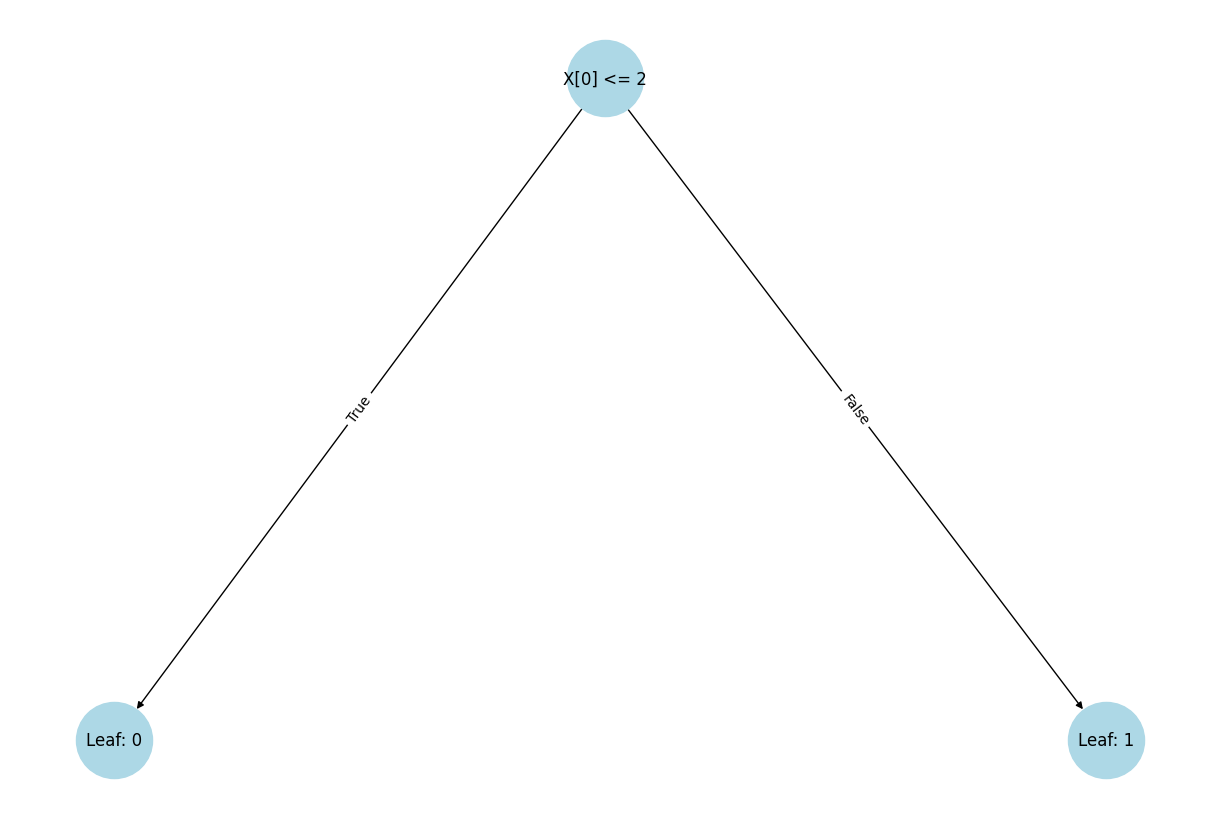

In [11]:
import numpy as np
from collections import Counter
import math

def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count/total) * math.log2(count/total) for count in counts.values())

def gini(y):
    counts = Counter(y)
    total = len(y)
    return 1 - sum((count/total)**2 for count in counts.values())

def information_gain(y, left, right, criterion="entropy"):
    if criterion == "entropy":
        impurity = entropy
    else:
        impurity = gini

    H_before = impurity(y)
    total = len(y)
    H_after = (len(left)/total) * impurity(left) + (len(right)/total) * impurity(right)
    return H_before - H_after

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # leaf value

    def is_leaf(self):
        return self.value is not None

class DecisionTreeClassifierScratch:
    def __init__(self, max_depth=10, min_samples_split=2, criterion="entropy"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(np.array(X), np.array(y), depth=0)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        n_samples, n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = X[:, feature] > t

                if sum(left_idx) == 0 or sum(right_idx) == 0:
                    continue

                gain = information_gain(
                    y,
                    y[left_idx],
                    y[right_idx],
                    criterion=self.criterion
                )

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = t

        return best_feature, best_threshold, best_gain

    def _grow_tree(self, X, y, depth):
        num_samples = len(y)
        num_labels = len(np.unique(y))

        # stopping conditions
        if (depth >= self.max_depth or
            num_labels == 1 or
            num_samples < self.min_samples_split):
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        feature, threshold, gain = self._best_split(X, y)

        if gain == -1:
            leaf_value = Counter(y).most_common(1)[0][0]
            return Node(value=leaf_value)

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature, threshold, left, right)

    def predict_one(self, x):
        node = self.root
        while not node.is_leaf():
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def predict(self, X):
        return np.array([self.predict_one(x) for x in X])

import matplotlib.pyplot as plt
import networkx as nx

def plot_tree(node):
    G = nx.DiGraph()

    def add_nodes_edges(node, parent=None, label=""):
        if node is None:
            return

        node_id = id(node)
        if node.is_leaf():
            G.add_node(node_id, label=f"Leaf: {node.value}")
        else:
            G.add_node(node_id, label=f"X[{node.feature}] <= {node.threshold}")

        if parent is not None:
            G.add_edge(parent, node_id, label=label)

        if not node.is_leaf():
            add_nodes_edges(node.left, node_id, "True")
            add_nodes_edges(node.right, node_id, "False")

    add_nodes_edges(node)

    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, "label")
    edge_labels = nx.get_edge_attributes(G, "label")

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=3000, node_color="lightblue")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.show()

X = [[2, 3], [1, 1], [3, 2], [2, 1], [3, 3]]
y = [0, 0, 1, 0, 1]

tree = DecisionTreeClassifierScratch(max_depth=3, criterion="entropy")
tree.fit(X, y)

print(tree.predict([[2, 2], [3, 3]]))

# Install graphviz-dev and pygraphviz if not already installed
!apt-get install -y graphviz-dev
!pip install pygraphviz --quiet

plot_tree(tree.root)
